In [1]:
import graphviz 
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import tree

import utils

from utils import local_data
from utils import window
from utils import Scale, give_error
from utils import smooth_signal
from utils import location_station, find_set_sunrise, find_set_sunset

%matplotlib inline
warnings.filterwarnings('ignore')

latter_size = 14
plt.rcParams['legend.fontsize'] = latter_size 
plt.rcParams['font.size'] = latter_size 
plt.rcParams['axes.labelsize'] = latter_size
plt.rcParams['xtick.labelsize'] = latter_size
plt.rcParams['ytick.labelsize'] = latter_size

In [2]:
df = pd.read_pickle('./data/sj2_analise.pkl')

In [3]:
df.head()

,vtec,vtec_dt,vtec_dt2,gvtec1,gvtec1_dt,gvtec2,gvtec2_dt,s4
2013-12-01 03:30:00,33.624428,-0.428246,-0.020502,-3.216613,0.002355,1.826065,1.991653,0.163334
2013-12-01 03:40:00,33.205025,-0.546589,-0.118343,-3.122300,0.130198,4.588494,2.530373,0.165397
2013-12-01 03:50:00,32.539631,-0.772594,-0.226005,-2.810556,0.280756,7.786990,2.862830,0.168683
2013-12-01 04:00:00,31.469337,-1.082859,-0.310265,-2.320938,0.399753,10.972091,2.894375,0.173552
2013-12-01 04:10:00,29.995466,-1.429647,-0.346788,-1.764129,0.443303,13.734955,2.621609,0.178917


### (1) Estimação de s4 com vtec

The scores for the k-fold crossvalidation was:
[-0.0030054  -0.00239556 -0.00314064 -0.00282555 -0.00334945 -0.00322243
 -0.00298324 -0.00297286 -0.00356719 -0.00305658] 

O erro quadrático médio foi: 0.002842
O erro quadrático total foi: 3.198431
O maior erro por previsão foi: 0.397578
O erro relativo foi: 12.720313%
O número de verdadeiros negativos foi: 2793
O número de verdadeiros positivos foi: 120
O número de falsos negativos foi: 257
O número de falsos positivos foi: 430
O POD foi: 0.318302
O FAR foi: 0.781818
A ACC foi: 0.809167
O kappa foi: 0.059367

Error for the time series sample:
O erro quadrático médio foi: 0.008768
O erro quadrático total foi: 2.432751
O maior erro por previsão foi: 0.590400
O erro relativo foi: 15.468693%
O número de verdadeiros negativos foi: 532
O número de verdadeiros positivos foi: 25
O número de falsos negativos foi: 59
O número de falsos positivos foi: 59
O POD foi: 0.297619
O FAR foi: 0.702381
A ACC foi: 0.825185
O kappa foi: 0.072127


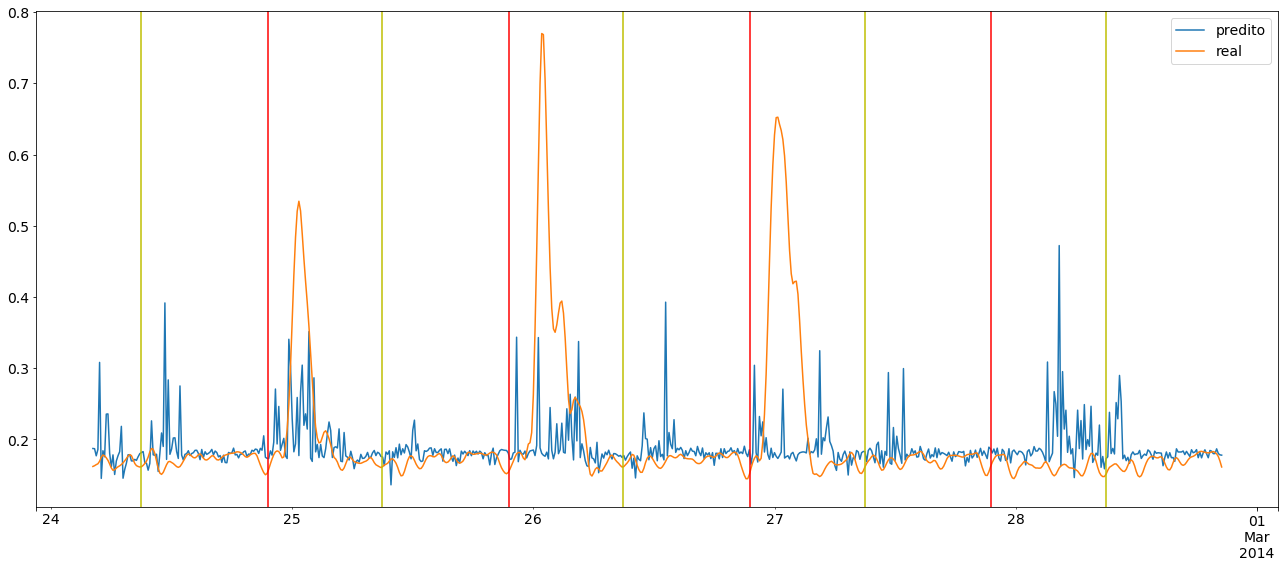

In [4]:
instances_set = ['vtec']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

# generate model, use k-fold crossvalidation and print scores
model = RandomForestRegressor()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predito'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predito'].values);

# plot the time series predict against the real values
ax = df_aux.plot(figsize=(18, 8));

lat, long = location_station('sj2')
set_of_sunrise = find_set_sunrise(df_aux, lat, long)
set_of_sunset = find_set_sunset(df_aux, lat, long)
for i in set_of_sunrise:
    ax.axvline(x=i, color='y')
for i in set_of_sunset[0:-1]:
    ax.axvline(x=i, color='r')

plt.tight_layout()
plt.savefig('./images/regression_random_florest_1.eps', format='eps', dpi=1000)

### (2) Estimação de s4 com vtec, vtec_dt e vtec_dt2

The scores for the k-fold crossvalidation was:
[-0.00184764 -0.00156658 -0.00181203 -0.00220266 -0.0020011  -0.00246199
 -0.00196094 -0.00182877 -0.00194382 -0.00200568] 

O erro quadrático médio foi: 0.001824
O erro quadrático total foi: 2.562486
O maior erro por previsão foi: 0.381457
O erro relativo foi: 10.077648%
O número de verdadeiros negativos foi: 2805
O número de verdadeiros positivos foi: 249
O número de falsos negativos foi: 128
O número de falsos positivos foi: 418
O POD foi: 0.660477
O FAR foi: 0.626687
A ACC foi: 0.848333
O kappa foi: 0.035735

Error for the time series sample:
O erro quadrático médio foi: 0.006943
O erro quadrático total foi: 2.164768
O maior erro por previsão foi: 0.515956
O erro relativo foi: 16.016545%
O número de verdadeiros negativos foi: 484
O número de verdadeiros positivos foi: 57
O número de falsos negativos foi: 27
O número de falsos positivos foi: 107
O POD foi: 0.678571
O FAR foi: 0.652439
A ACC foi: 0.801481
O kappa foi: 0.042067


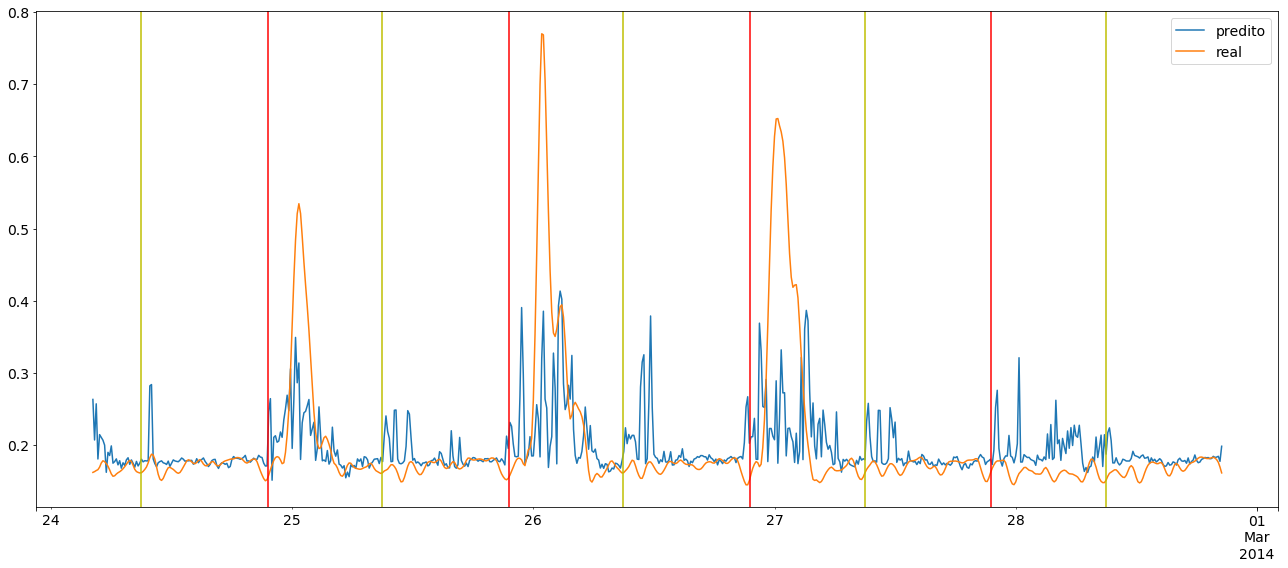

In [5]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

# generate model, use k-fold crossvalidation and print scores
model = RandomForestRegressor()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predito'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predito'].values);

# plot the time series predict against the real values
ax = df_aux.plot(figsize=(18, 8));

lat, long = location_station('sj2')
set_of_sunrise = find_set_sunrise(df_aux, lat, long)
set_of_sunset = find_set_sunset(df_aux, lat, long)
for i in set_of_sunrise:
    ax.axvline(x=i, color='y')
for i in set_of_sunset[0:-1]:
    ax.axvline(x=i, color='r')

plt.tight_layout()
plt.savefig('./images/regression_random_florest_2.eps', format='eps', dpi=1000)

### (3) Estimação de S4 com vtec, gvtec1 e gvtec2

The scores for the k-fold crossvalidation was:
[-0.00164407 -0.00139567 -0.00170737 -0.00184801 -0.0015003  -0.00147936
 -0.00165684 -0.0013806  -0.00156129 -0.00159931] 

O erro quadrático médio foi: 0.001408
O erro quadrático total foi: 2.251312
O maior erro por previsão foi: 0.359792
O erro relativo foi: 8.678549%
O número de verdadeiros negativos foi: 2916
O número de verdadeiros positivos foi: 262
O número de falsos negativos foi: 115
O número de falsos positivos foi: 307
O POD foi: 0.694960
O FAR foi: 0.539543
A ACC foi: 0.882778
O kappa foi: 0.032081

Error for the time series sample:
O erro quadrático médio foi: 0.006559
O erro quadrático total foi: 2.104155
O maior erro por previsão foi: 0.553163
O erro relativo foi: 15.036721%
O número de verdadeiros negativos foi: 518
O número de verdadeiros positivos foi: 58
O número de falsos negativos foi: 26
O número de falsos positivos foi: 73
O POD foi: 0.690476
O FAR foi: 0.557252
A ACC foi: 0.853333
O kappa foi: 0.038852


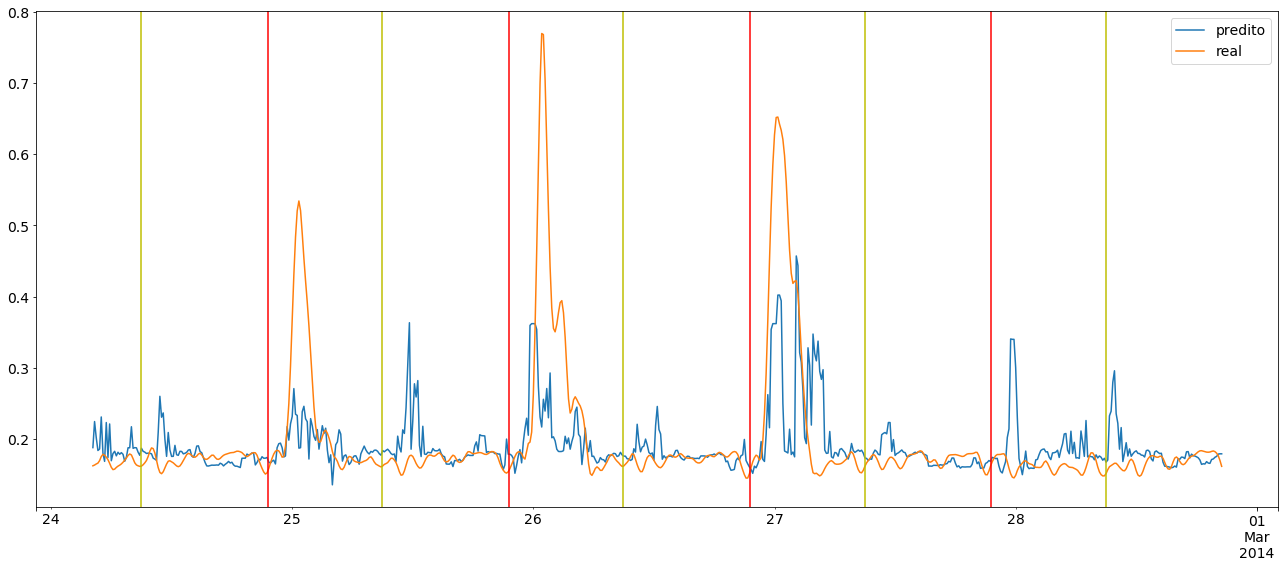

In [6]:
instances_set = ['vtec', 'gvtec1', 'gvtec2']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

# generate model, use k-fold crossvalidation and print scores
model = RandomForestRegressor()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predito'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predito'].values);

# plot the time series predict against the real values
ax = df_aux.plot(figsize=(18, 8));

lat, long = location_station('sj2')
set_of_sunrise = find_set_sunrise(df_aux, lat, long)
set_of_sunset = find_set_sunset(df_aux, lat, long)
for i in set_of_sunrise:
    ax.axvline(x=i, color='y')
for i in set_of_sunset[0:-1]:
    ax.axvline(x=i, color='r')

plt.tight_layout()
plt.savefig('./images/regression_random_florest_3.eps', format='eps', dpi=1000)